In [64]:
import numpy as np 
import numpy.random as rand
import matplotlib.pyplot as plt

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
from PIL import Image


# Forward Process

In [61]:
T=500
IMG_SIZE=128

def noise_schedule(start=0.0001, stop=0.02, num=T):
    return np.linspace(start=start, stop=stop, num=num)

betas=noise_schedule()
alphas=1-betas
alphas_cumprod=np.cumprod(alphas)
sqrt_alphas_cumprod=np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod=np.sqrt(1-alphas_cumprod)

def forward_diffusion_process(x0, t):
    """
    Get noisy image of x0 obtained after t timesteps
    """
    noise=rand.standard_normal(size=x0.shape)
    return sqrt_alphas_cumprod[t]*x0+sqrt_one_minus_alphas_cumprod[t]*noise, noise

def sample_timesteps(num):
    return rand.choice(range(T),size=num)

# Reduces image resolution
def transform_img(image : Image):
    """
    Horizontal flips given image with random probability
    and scales it to values between -1 and 1.
    """
    image.thumbnail((IMG_SIZE,IMG_SIZE))
    prob=rand.random()

    if prob>0.5:
        image=image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    img_arr=np.array(image).astype(np.float32)

    #Scale between -1 and 1
    img_arr=2*img_arr/255-1

    return img_arr

def reverse_transform_img(img_arr):
    """
    Given an image array scales it back to valid RGB
    """
    img_arr=(img_arr+1)/2
    img_arr*=255
    img_arr=np.array(img_arr).astype(np.uint8)
    return img_arr


### Example

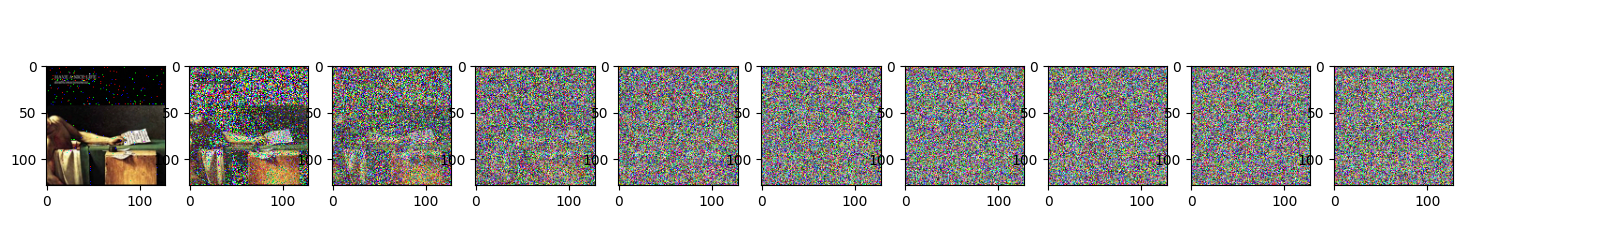

In [62]:
im=Image.open("test_img.jpg")
img=transform_img(im)

plt.figure(figsize=(20,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for t in range(0, T, stepsize):
    plt.subplot(1, num_images+1, int(t/stepsize) + 1)
    noisy_img, noise = forward_diffusion_process(img, t)
    noisy_img=reverse_transform_img(noisy_img)
    plt.imshow(noisy_img)

## Data Loading

In [55]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #transforms.RandomHorizontalFlip(), - Não faz sentido para este dataset
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    mnist = torchvision.datasets.MNIST(root=".", download=True,
                                         transform=data_transform)
    return mnist

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image), cmap='gray')

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

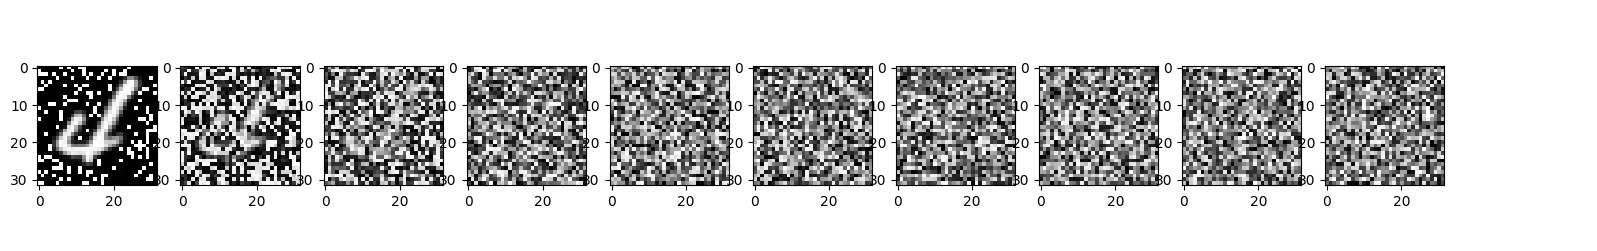

In [56]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(20,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_process(image, t)
    show_tensor_image(img)

# Backward Process

In [79]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        
# Used in the encoder part of the UNet
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    #Uses positional embeddings
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

# Used in the decoder part of the UNet
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    #Uses both positional embeddings and skip connections
    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    
class SimplifiedUNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Downsample(64, 128)
        #self.sa1 = SelfAttention(128, 32)
        self.down2 = Downsample(128, 256)
        #self.sa2 = SelfAttention(256, 16)
        self.down3 = Downsample(256, 256)
        #self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Upsample(512, 128)
        #self.sa4 = SelfAttention(128, 16)
        self.up2 = Upsample(256, 64)
        #self.sa5 = SelfAttention(64, 32)
        self.up3 = Upsample(128, 64)
        #self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        #x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        #x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        #x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        #x = self.sa4(x)
        x = self.up2(x, x2, t)
        #x = self.sa5(x)
        x = self.up3(x, x1, t)
        #x = self.sa6(x)
        output = self.outc(x)
        return output
    
#cin e cout ser 1D ou 3D faz mesmo muito pouca diferença (se calhar podemos usar imagens a cores)
model = SimplifiedUNet(c_in=1, c_out=1)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  22291587


SimplifiedUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Downsample(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): Sequ